In [2]:
# libraries
import pandas as pd
import numpy as np
import pickle as pkl 
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.dates import DateFormatter
import sys
sys.path.append("../functions/")
from plot_style import plot_style
colors = plot_style("../functions/fonts/")
from correlations import pearsonr_CI, partial_corr
from matplotlib.lines import Line2D
from import_functions import *

# first and last Monday
start_date, end_date  = datetime(2020, 3, 2), datetime(2020, 12, 21)
window = timedelta(days=7)
dates = pd.to_datetime(np.arange(start_date, end_date + window, window))

../functions/plot_style.py:21: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


# Correlation Analysis

First we compute the correlations between NPIs adherence and average download speed by week using several controls:

In [3]:
def get_corrs_intime(country, col, covs, th=5):
    
    """
    This function computes the correlation in time
    :param country: country name
    :param col: name of mobility metric column
    :param covs: list of covariates
    :param th: number of obs needed to compute the correlation (days over 5-day week)
    :return: dictionary of correlations
    """
           
    # import data 
    gadm2, maps, policy = import_gadm(country, path_to_data="../../data/"), import_range_maps(country, path_to_data="../../data/"), import_policy(country, path_to_data="../../data/")
    
    # keep gadm2 for which we have mobility data
    gadm2 = gadm2.loc[gadm2.GID_2.isin(maps.polygon_id.unique())]
    
    stringency = []
    corrs, partial_corrs= {"median": [], "q025": [], "q975": []}, {"pearson": {}, "spearman": {}}
    for cov in covs:
        partial_corrs["pearson"][cov] = {"median": [], "q025": [], "q975": []}
        partial_corrs["spearman"][cov] = {"median": [], "q025": [], "q975": []}
    partial_corrs["pearson"]["all"] = {"median": [], "q025": [], "q975": []}
    partial_corrs["spearman"]["all"] = {"median": [], "q025": [], "q975": []}
    
    for date in dates:
        
        print(date)
        df_date = maps.loc[(maps.ds >= date) & (maps.ds < date + timedelta(days=5))]
        policy_date = policy.loc[(policy.index >= date) & (policy.index < date + timedelta(days=5))]
        stringency.append(policy_date.StringencyIndex.mean())
        
        mvmt, downs, covs_values = [], [], {}
        for cov in covs:
            covs_values[cov] = []
            
        for index, row in gadm2.iterrows():

            # loc data in this time range
            df_date_gid2 = df_date.loc[df_date.polygon_id == row.GID_2]

            # if enough data
            if df_date_gid2.shape[0] >= th:

                # get average movement change
                mvmt.append(df_date_gid2[col].mean())
                downs.append(row.download_mbps_fixed)
                for cov in covs:
                    covs_values[cov].append(row[cov])

        med, q025, q975 = pearsonr_CI(mvmt, downs)
        corrs["median"].append(med)
        corrs["q025"].append(q025)
        corrs["q975"].append(q975)
    
        # partial corrs
        for method in ['pearson', 'spearman']:
            all_covs = []
            for cov in covs:
                med, q025, q975 = partial_corr(mvmt, downs, [covs_values[cov]], method=method)
                partial_corrs[method][cov]["median"].append(med)
                partial_corrs[method][cov]["q025"].append(q025)
                partial_corrs[method][cov]["q975"].append(q975)
                all_covs.append(covs_values[cov])
                
            med, q025, q975 = partial_corr(mvmt, downs, all_covs, method=method)
            partial_corrs[method]["all"]["median"].append(med)
            partial_corrs[method]["all"]["q025"].append(q025)
            partial_corrs[method]["all"]["q975"].append(q975)
        
    return corrs, partial_corrs, stringency

# compute corrs
run = False
if run:
    corrs = {}
    for country in ['colombia', 'el-salvador', 'ecuador']:
        print(country)
        corrs[country] = {}

        if country == "colombia":
            covs = ['rwi_weight', 'popDANE', 'pop_density', 'gdp_per_capita']
        elif country in ["el-salvador", "ecuador"]:
            covs = ['rwi_weight', 'pop2020', 'pop_density', 'gdp_per_capita']

        for col in ['all_day_bing_tiles_visited_relative_change', 'all_day_ratio_single_tile_users']:
            print(col)
            pearson, partial_pearson, stringency = get_corrs_intime(country, col, covs)
            corrs[country][col] = {"corrs": pearson, "partial_corrs": partial_pearson}

        corrs[country]["stringency"] = stringency
    with open("./correlations-in-time/corrs.pkl", "wb") as file:
        pkl.dump(corrs, file)

with open("./correlations-in-time/corrs.pkl", "rb") as file:
    corrs = pkl.load(file)

Second we plot results:

In [4]:
def plot_policy(ax_str, country, color):

    """
    This function plot the stringency index
    :param ax_str: axis
    :param country: name of the country
    :param color: color to use
    """
    
    # import data
    policy = import_policy(country, path_to_data="../../data/")
    # stringency index
    ax_str.plot(policy["StringencyIndex"], color=color, linestyle='--')

    # format dates
    date_form = DateFormatter("%b, %y")
    ax_str.xaxis.set_major_formatter(date_form)

    # labels and title
    ax_str.tick_params(axis="x", rotation=30)
    ax_str.set_ylabel("Stringency Index", fontsize=10, rotation=270, color=color)
    ax_str.yaxis.set_label_coords(x=1.1, y=0.5)
    ax_str.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax_str.spines['right'].set_edgecolor(color)
    ax_str.tick_params(axis="y", color=color, labelcolor=color)
    # spines
    ax_str.spines["top"].set_visible(False)
    ax_str.tick_params(axis="y", labelsize=8)

    # ax lim
    ax_str.set_ylim(0, 105)

def scatter_plot(country, ax, ycol, ylabel):
    
    """
    This function plot the maximum NPIs adherence against the average download speed
    :param country: name of the country
    :param ax: axis
    :param ycol name of the mobility metric 
    :param ylabel: y label
    """

    if ycol == 'all_day_bing_tiles_visited_relative_change':
        mult = -1
    else:
        mult = +1 
        
    # import data and keep gadm2 for which we have mobility data
    gadm2, maps, policy = import_gadm(country, "../../data/"), import_range_maps(country, "../../data/"), import_policy(country, "../../data/")
    gadm2 = gadm2.loc[gadm2.GID_2.isin(maps.polygon_id.unique())]

    # mobility - keep only 2020 
    maps = maps.loc[(maps.ds >= datetime(2020, 1, 1)) & (maps.ds < datetime(2021, 1, 1))]

    # mobility - remove weekends
    maps = maps.loc[maps.ds.dt.dayofweek < 5].reset_index(drop=True)

    movs = {}
    for date in dates:
        maps_date = maps.loc[(maps.ds >= date) & (maps.ds < date + timedelta(days=5))]
        for gid_2 in maps_date.polygon_id.unique():
            maps_date_gid2 = maps_date.loc[maps_date.polygon_id == gid_2]
            if maps_date_gid2.shape[0] == 5:
                if gid_2 not in movs.keys():
                    movs[gid_2] = []
                movs[gid_2].append(mult * 100 * maps_date_gid2[ycol].mean())
                
    max_movs, mbps, rwis = [], [], []
    for gid_2 in movs.keys():
        if len(movs[gid_2]) == len(dates):
            max_movs.append(np.max(movs[gid_2]))
            mbps.append(gadm2.loc[gadm2.GID_2 == gid_2].download_mbps_fixed.values[0])
            rwis.append(gadm2.loc[gadm2.GID_2 == gid_2].rwi_weight.values[0])
        
    line = sns.regplot(mbps, max_movs, ax=ax, color=colors[1], 
                      scatter_kws={'edgecolor':  'white', 'linewidth': 0.3, 'alpha': 0.7},
                line_kws={"linewidth": 1.5})
    ax.set_xlabel("Mbps", fontsize=8)
    ax.set_ylabel(ylabel, fontsize=8)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis="y", labelsize=8)
    ax.tick_params(axis="x", labelsize=8)
    ax.yaxis.set_major_locator(MaxNLocator(prune='both', nbins=5))

    
    p, c1, c2 = pearsonr_CI(mbps, max_movs)
    p_pr , c1_pr , c2_pr = partial_corr(mbps, max_movs, cov=[rwis], method='pearson')
    print("{0} - {1}".format(country, ycol))
    print("Pearson: {0} [{1}; {2}]".format(p, c1, c2))
    print("Variance Explained: {0}".format(p**2))
    print("Partial Pearson: {0} [{1}; {2}]".format(p_pr, c1_pr, c2_pr))
    x2, x1 = line.get_lines()[0].get_xdata()[-1], line.get_lines()[0].get_xdata()[0]
    y2, y1 = line.get_lines()[0].get_ydata()[-1], line.get_lines()[0].get_ydata()[0]
    print("Slope: {0}".format((y2 - y1) / (x2 - x1)))
    print("Increase caused by 10 mbps: {0}\n\n".format(10 * (y2 - y1) / (x2 - x1)))


def plot_correlation(country, mob_column, color, ax, return_legend=False):
    """
    This function plot the correlation between wekly NPIs adherence and average download speed
    :param country: name of the country
    :param ax: axis
    :param mob_column: name of the mobility metric 
    :param color: color
    :param return_legend: if True return legend
    """
    
    if mob_column == 'all_day_bing_tiles_visited_relative_change':
        mult = -1
    else:
        mult = +1 
    
    p1, = ax.plot(dates, mult * np.array(corrs[country][mob_column]['corrs']['median']), color=color)
    p2 = ax.fill_between(dates, 
                         mult * np.array(corrs[country][mob_column]['corrs']['q025']),
                         mult * np.array(corrs[country][mob_column]['corrs']['q975']), alpha=0.3, linewidth=0, color=color)
    
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel("correlation", fontsize=8)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_major_locator(MaxNLocator(prune='both', nbins=5))
    ax.set_ylim(-0.3, 0.7)
    ax.tick_params(axis="y", labelsize=8)
    ax.tick_params(axis="x", labelsize=8)
    
    if return_legend:
        return p1, p2
    
    
def plot_correlation_panel(ycol, savename, ylabel):
    fig, axes = plt.subplot_mosaic([["A", "B", "B"], 
                                ["C", "D", "D"], 
                                ["E", "F", "F"]], dpi=500, figsize=(7,5))

    for country, title, ax1, ax2 in zip(["colombia", "ecuador", "el-salvador"], ["Colombia", "Ecuador", "El Salvador"],
                                        [axes["A"], axes["C"], axes["E"]], [axes["B"], axes["D"], axes["F"]]):
        scatter_plot(country, ax1, ycol, ylabel)
        plot_correlation(country, ycol, colors[0], ax2)
        plot_policy(ax2.twinx(), country, "#FBB9AB")
        ax1.set_title(title)
        ax2.set_title(title)

    fig.suptitle("Digital Infrastructure Quality and Mobility Changes", weight='bold', y=1, fontsize=12)
    plt.tight_layout()    
    fig.add_artist(Line2D([0.318,0.318], [0.01, 0.93], color="gray", linewidth=0.5, linestyle='dotted'))

    axes["A"].annotate(xy=(-0.25,1.3), xycoords="axes fraction", text="A", weight='bold', fontsize=12)
    axes["B"].annotate(xy=(-0.12,1.3), xycoords="axes fraction", text="B", weight='bold', fontsize=12)

    plt.savefig("./img/panel_correlations_" + savename +".pdf", bbox_inches='tight')

/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


colombia - all_day_bing_tiles_visited_relative_change
Pearson: 0.6188095417831141 [0.5538749931274906; 0.6762618367586186]
Variance Explained: 0.3829252490018276
Partial Pearson: 0.3198378805577981 [0.23; 0.41]
Slope: 1.271478614077285
Increase caused by 10 mbps: 12.714786140772851




/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ecuador - all_day_bing_tiles_visited_relative_change
Pearson: 0.34126673797474016 [0.19405889021601308; 0.47344365759078516]
Variance Explained: 0.11646298644791996
Partial Pearson: 0.2881368804666754 [0.14; 0.43]
Slope: 0.43872397956776166
Increase caused by 10 mbps: 4.387239795677616




/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


el-salvador - all_day_bing_tiles_visited_relative_change
Pearson: 0.6076845339648556 [0.39107441011815147; 0.760506874191965]
Variance Explained: 0.3692804928200837
Partial Pearson: 0.4019470225688043 [0.13; 0.62]
Slope: 1.9291917034886386
Increase caused by 10 mbps: 19.291917034886385




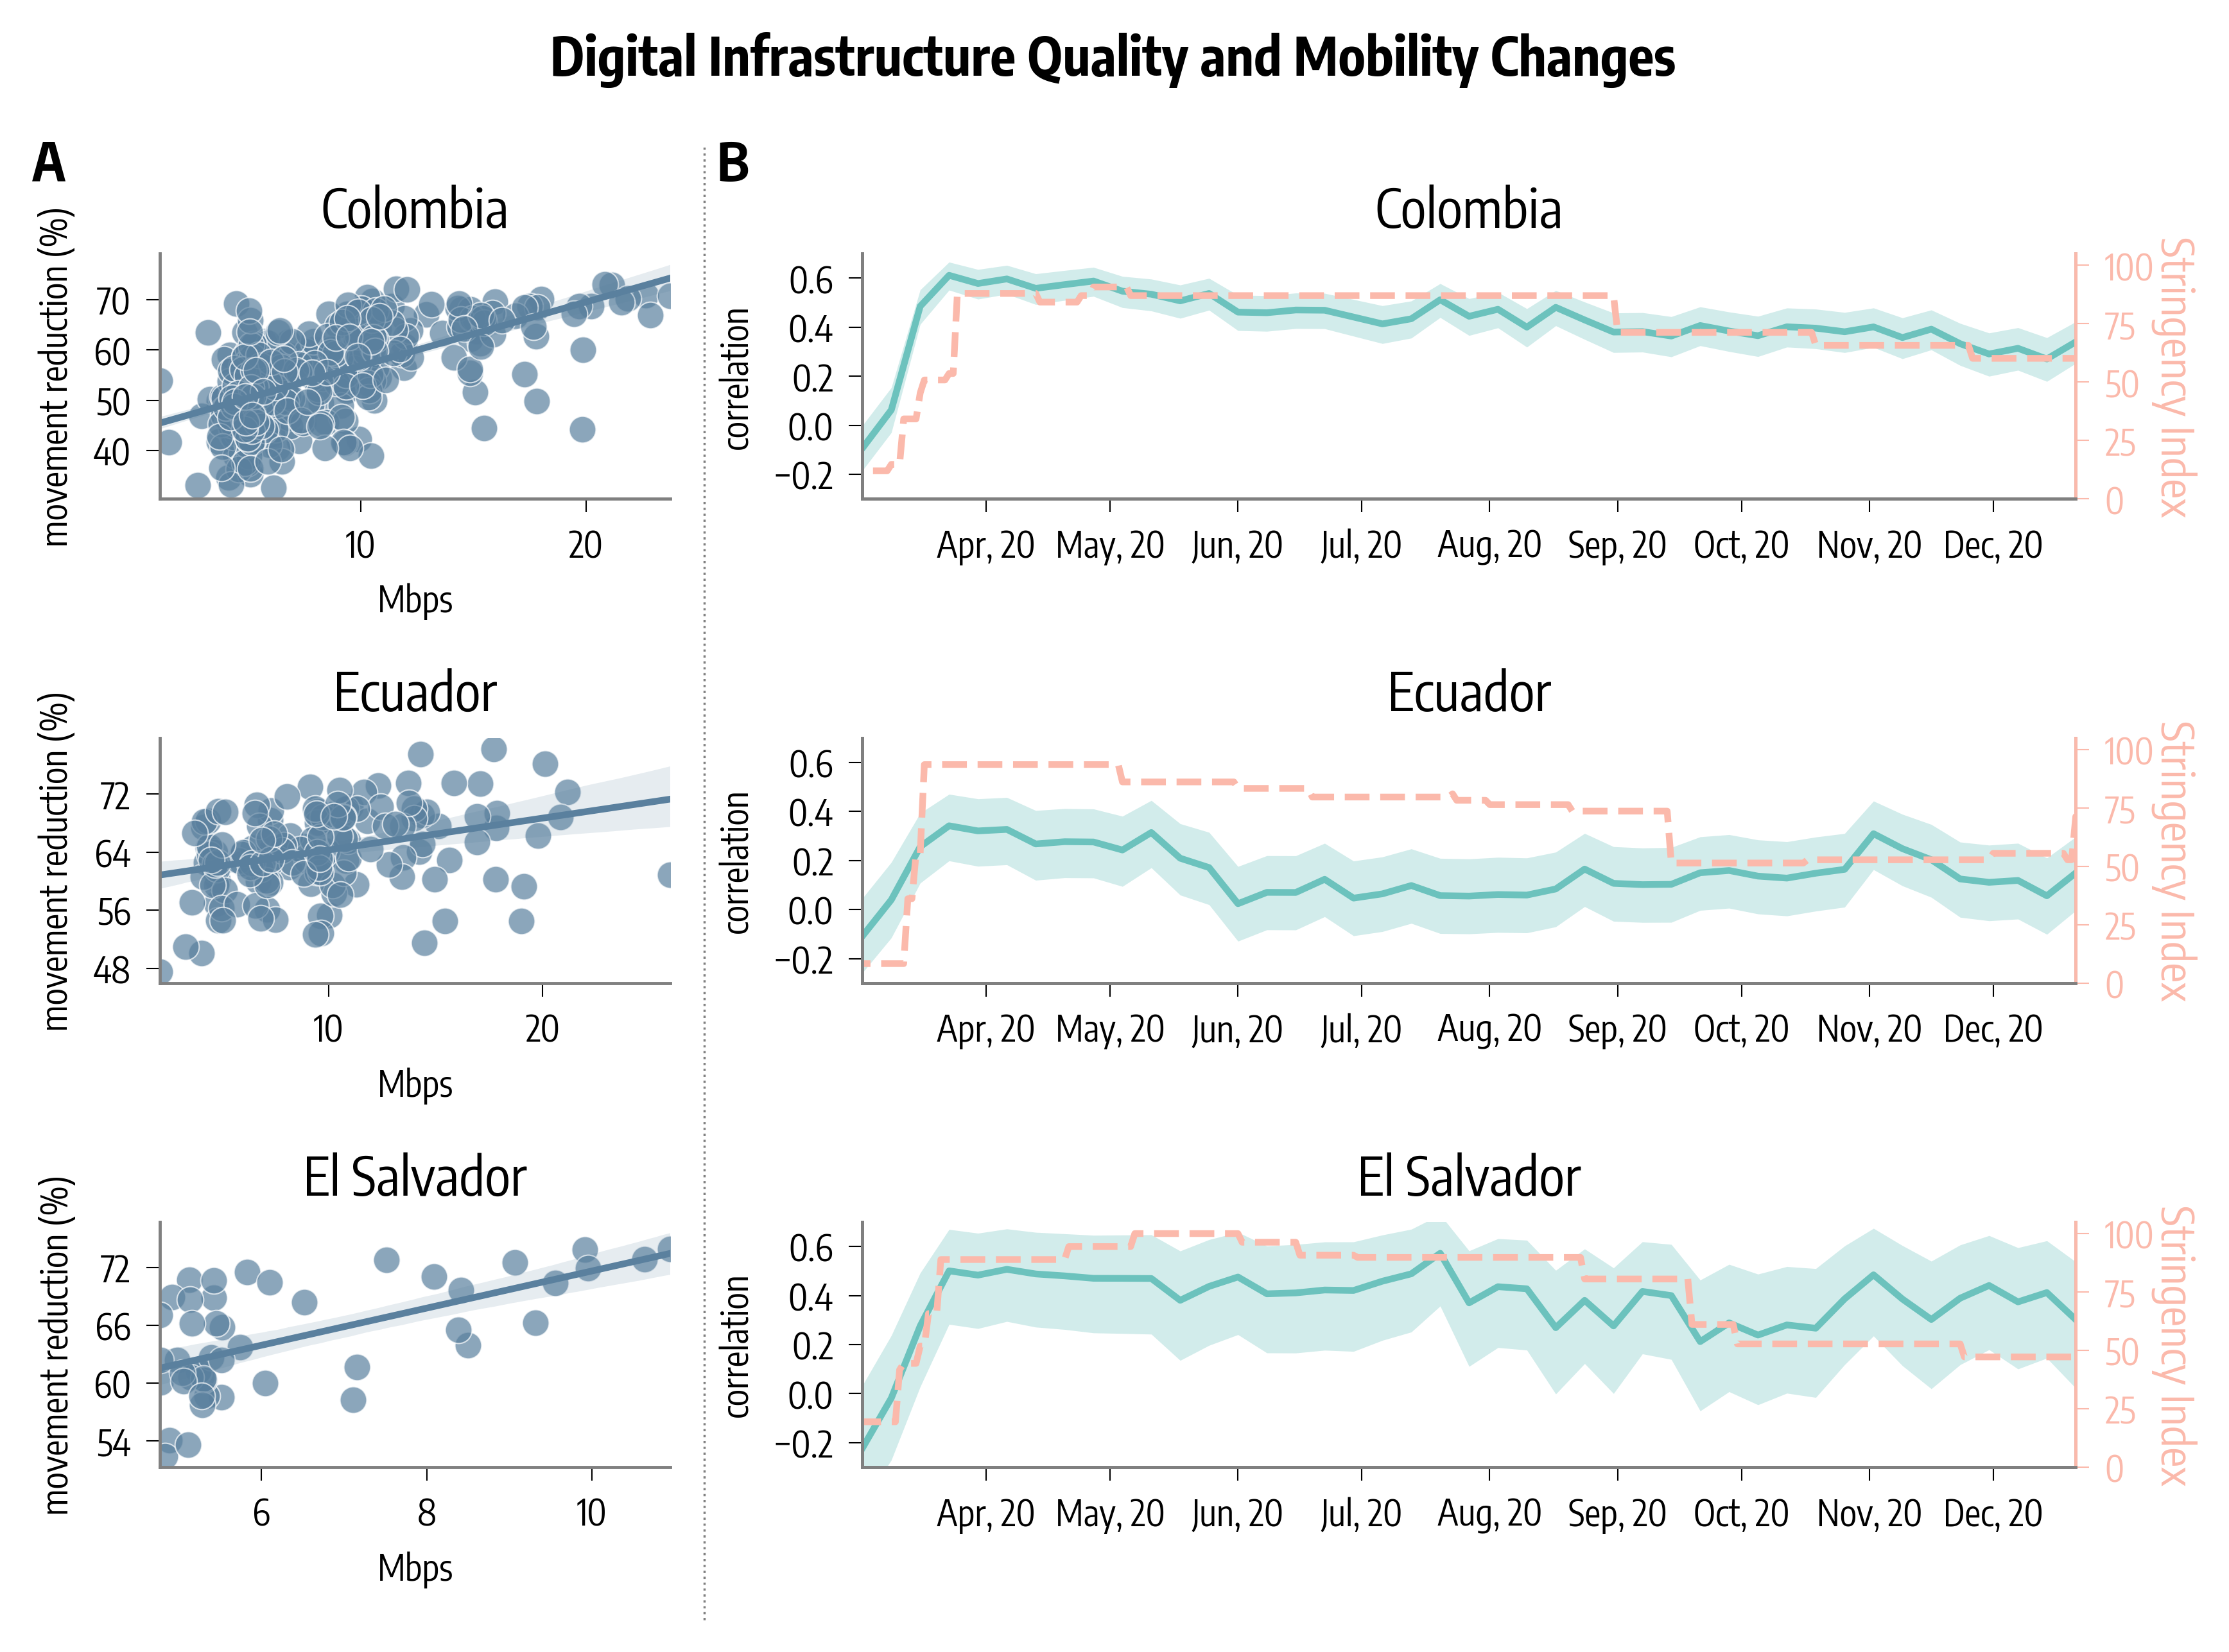

In [5]:
plot_correlation_panel('all_day_bing_tiles_visited_relative_change', "max_movs", "movement reduction (%)")

/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


colombia - all_day_ratio_single_tile_users
Pearson: 0.5445280629902622 [0.47107431440748504; 0.6104820438521749]
Variance Explained: 0.296510811383927
Partial Pearson: 0.2668770805655035 [0.17; 0.36]
Slope: 1.0523981695316684
Increase caused by 10 mbps: 10.523981695316683




/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/st

ecuador - all_day_ratio_single_tile_users
Pearson: 0.4655144172973497 [0.33224912333643386; 0.5805570096983664]
Variance Explained: 0.21670367271169105
Partial Pearson: 0.4350895230122654 [0.3; 0.56]
Slope: 0.7074864241684828
Increase caused by 10 mbps: 7.0748642416848275




/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


el-salvador - all_day_ratio_single_tile_users
Pearson: 0.5797553622965504 [0.3539216947310359; 0.7417093127024112]
Variance Explained: 0.3361162801116045
Partial Pearson: 0.37369495599526126 [0.1; 0.6]
Slope: 1.5878417278332138
Increase caused by 10 mbps: 15.878417278332137




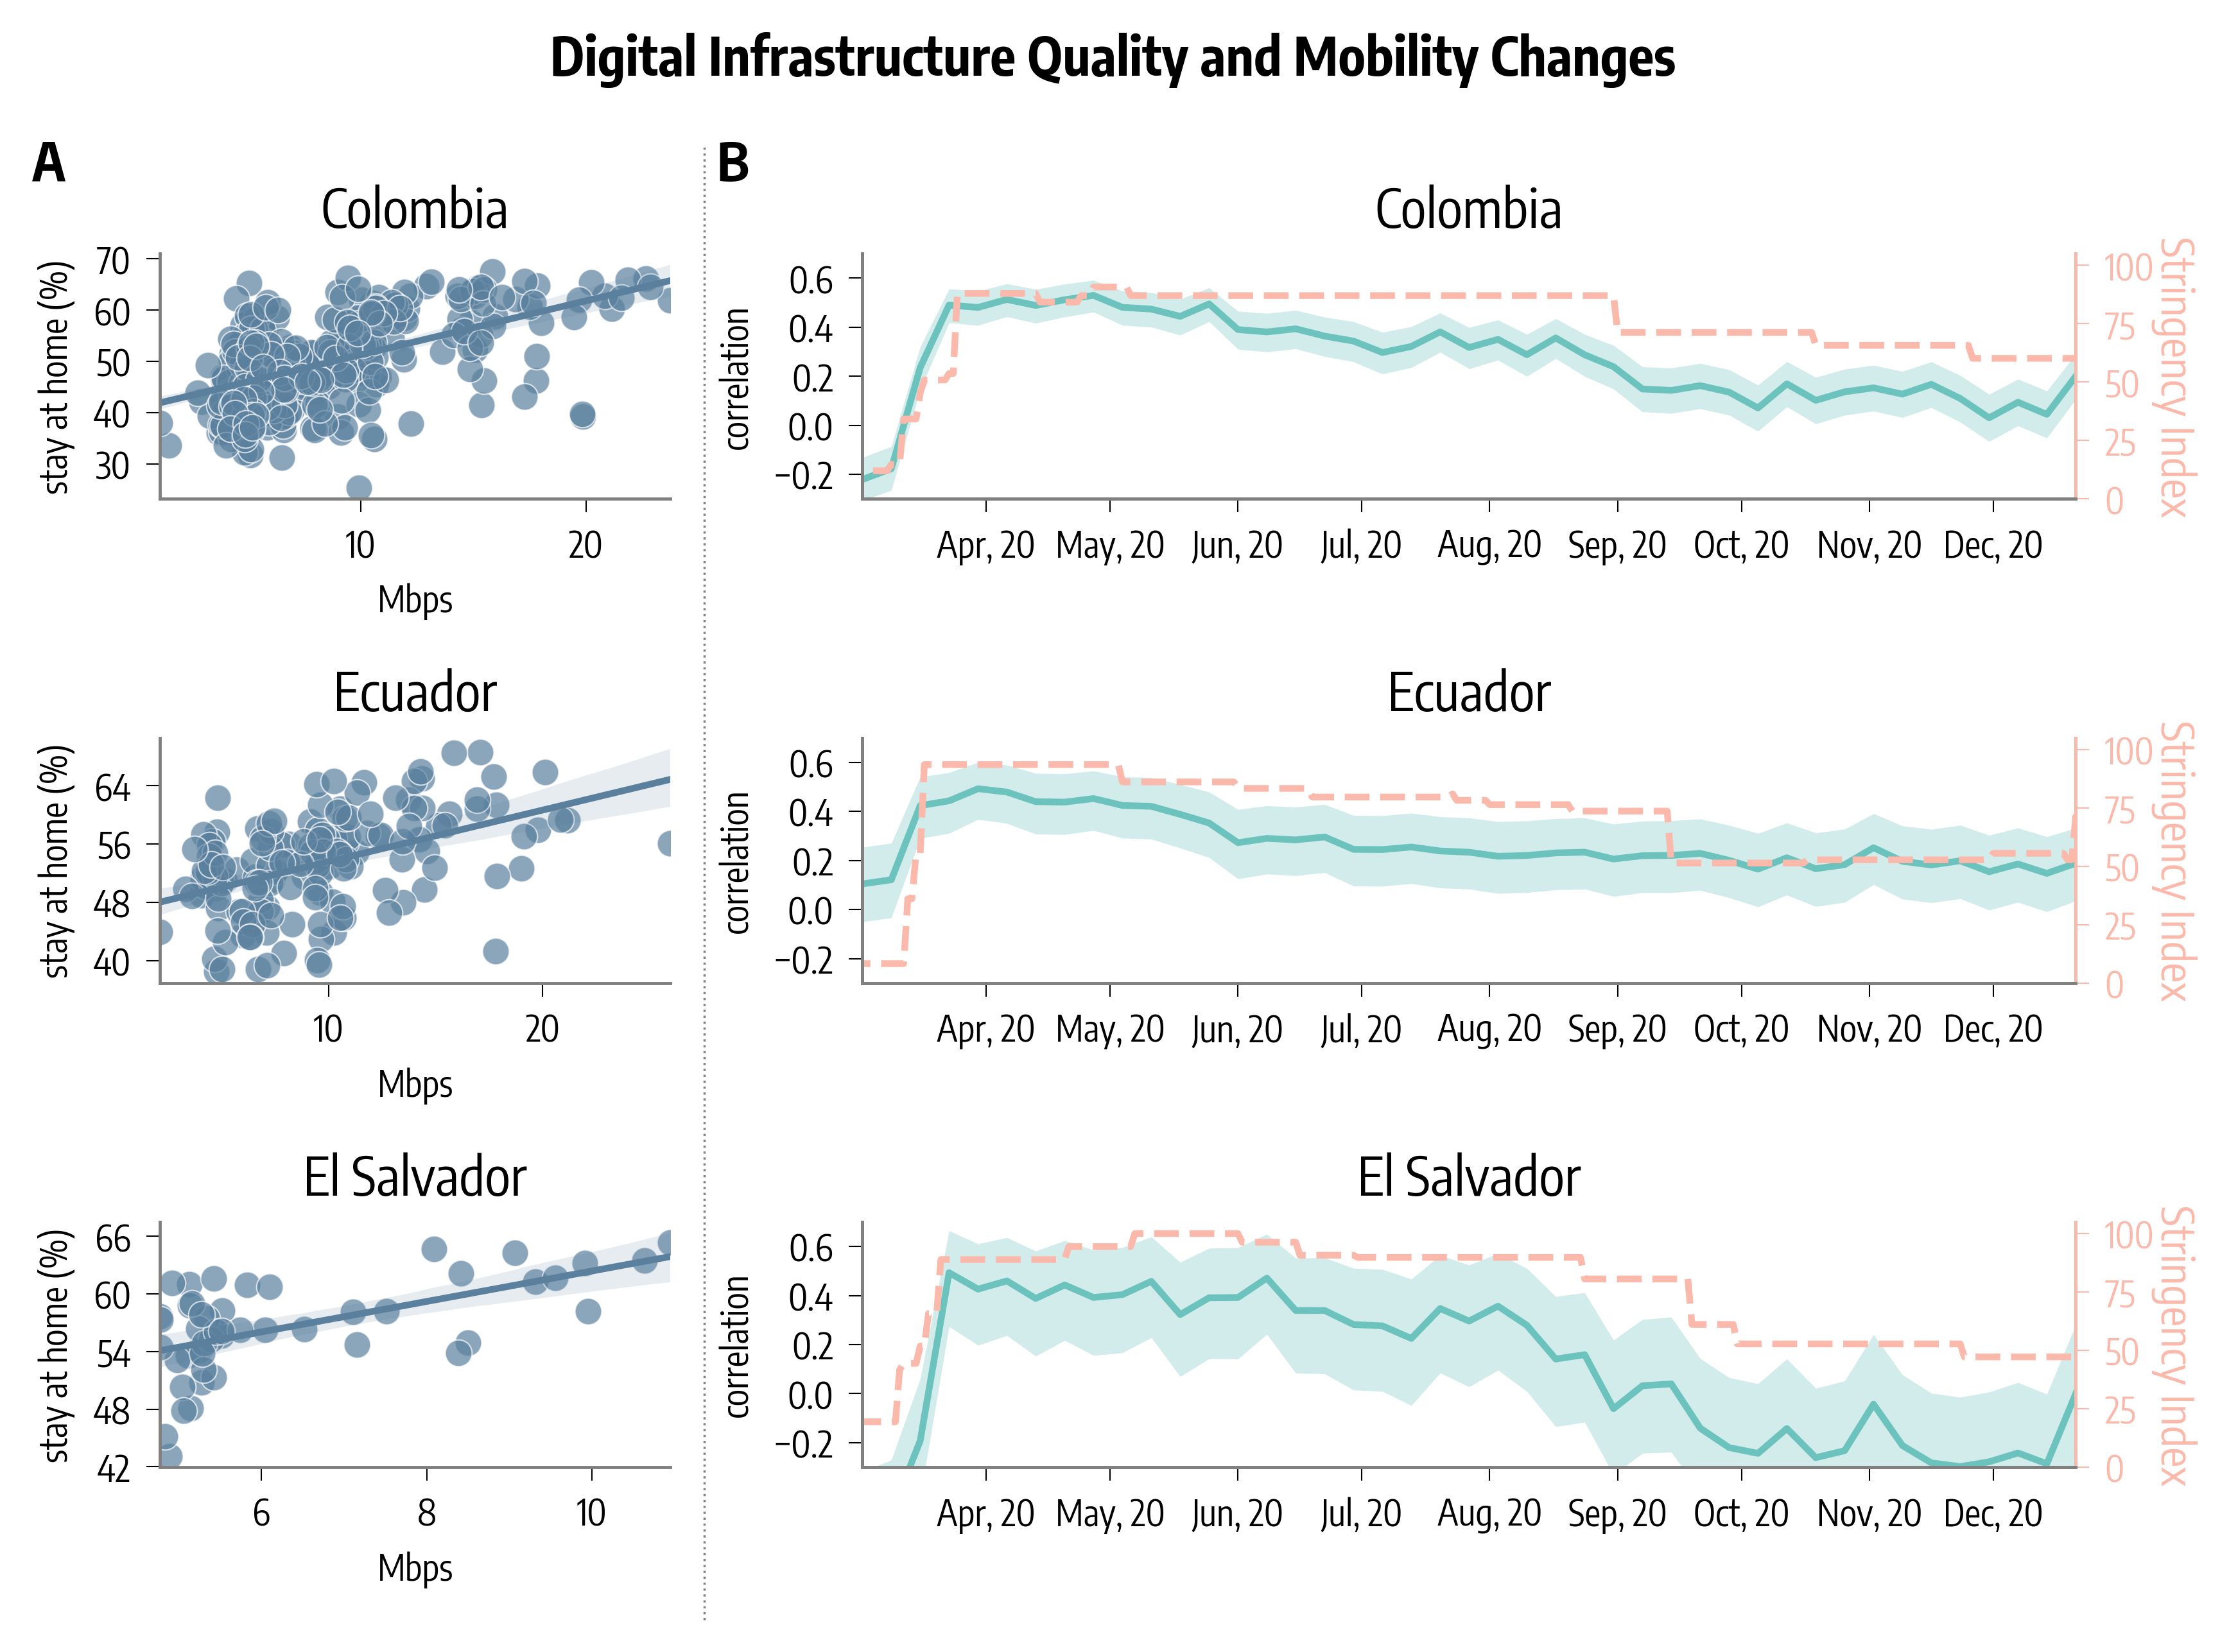

In [23]:
plot_correlation_panel('all_day_ratio_single_tile_users', "max_stay", "stay at home (%)")

# Supplementary Information check

As a supplementary check we show the partial correlations using several controls:

In [15]:
# SI partial corrs
def partial_corrs_SI(country, popcol, ycol):
    
    if ycol == 'all_day_bing_tiles_visited_relative_change':
        mult = -1
    else:
        mult = +1 

    # import data 
    gadm2, maps, policy = import_gadm(country, path_to_data="../../data/"), import_range_maps(country, path_to_data="../../data/"), import_policy(country, path_to_data="../../data/")

    # keep gadm2 for which we have mobility data
    gadm2 = gadm2.loc[gadm2.GID_2.isin(maps.polygon_id.unique())]

    # mobility - keep only 2020 
    maps = maps.loc[(maps.ds >= datetime(2020, 1, 1)) & (maps.ds < datetime(2021, 1, 1))]

    # mobility - remove weekends
    maps = maps.loc[maps.ds.dt.dayofweek < 5].reset_index(drop=True)

    movs = {}
    for date in dates:
        maps_date = maps.loc[(maps.ds >= date) & (maps.ds < date + timedelta(days=5))]
        for gid_2 in maps_date.polygon_id.unique():
            maps_date_gid2 = maps_date.loc[maps_date.polygon_id == gid_2]
            if maps_date_gid2.shape[0] == 5:
                if gid_2 not in movs.keys():
                    movs[gid_2] = []
                movs[gid_2].append(mult * 100 * maps_date_gid2[ycol].mean())
                
    max_movs, mbps, rwis = [], [], []
    pop60plus, gdp_per_capita, pop_density, pop = [], [], [], []

    for gid_2 in movs.keys():
        if len(movs[gid_2]) == len(dates):
            max_movs.append(np.max(movs[gid_2]))
            mbps.append(gadm2.loc[gadm2.GID_2 == gid_2].download_mbps_fixed.values[0])
            rwis.append(gadm2.loc[gadm2.GID_2 == gid_2].rwi_weight.values[0])
            pop60plus.append(gadm2.loc[gadm2.GID_2 == gid_2].pop60plus.values[0])
            pop_density.append(gadm2.loc[gadm2.GID_2 == gid_2].pop_density.values[0])
            pop.append(gadm2.loc[gadm2.GID_2 == gid_2][popcol].values[0])
            gdp_per_capita.append(gadm2.loc[gadm2.GID_2 == gid_2].gdp_per_capita.values[0])     
    
    print("{0}, {1}".format(country, ycol))
    p, c1, c2 = pearsonr_CI(mbps, max_movs)
    print("\tPearson: {0} [{1}; {2}]".format(np.round(p, 2) , np.round(c1, 2) , np.round(c2, 2)))
    p_pr , c1_pr , c2_pr = partial_corr(mbps, max_movs, cov=[rwis], method='pearson')
    print("\tRWI: {0} [{1}; {2}]".format(np.round(p_pr, 2) , np.round(c1_pr, 2) , np.round(c2_pr, 2)))
    p_pr , c1_pr , c2_pr = partial_corr(mbps, max_movs, cov=[gdp_per_capita], method='pearson')
    print("\tGDP: {0} [{1}; {2}]".format(np.round(p_pr, 2) , np.round(c1_pr, 2) , np.round(c2_pr, 2)))
    p_pr , c1_pr , c2_pr = partial_corr(mbps, max_movs, cov=[pop60plus], method='pearson')
    print("\t60+: {0} [{1}; {2}]".format(np.round(p_pr, 2) , np.round(c1_pr, 2) , np.round(c2_pr, 2)))
    p_pr , c1_pr , c2_pr = partial_corr(mbps, max_movs, cov=[pop_density], method='pearson')
    print("\tDensity: {0} [{1}; {2}]".format(np.round(p_pr, 2) , np.round(c1_pr, 2) , np.round(c2_pr, 2)))
    p_pr , c1_pr , c2_pr = partial_corr(mbps, max_movs, cov=[pop], method='pearson')
    print("\tPopulation: {0} [{1}; {2}]".format(np.round(p_pr, 2) , np.round(c1_pr, 2) , np.round(c2_pr, 2)))
    
    p_pr , c1_pr , c2_pr = partial_corr(mbps, max_movs, cov=[rwis, pop60plus, gdp_per_capita, pop_density, pop], method='pearson')
    print("\tAll: {0} [{1}; {2}]".format(np.round(p_pr, 2) , np.round(c1_pr, 2) , np.round(c2_pr, 2)))
    print("\n\n")

In [16]:
partial_corrs_SI("colombia", "popDANE", "all_day_bing_tiles_visited_relative_change")
partial_corrs_SI("ecuador", "pop2020", "all_day_bing_tiles_visited_relative_change")
partial_corrs_SI("el-salvador", "pop2020", "all_day_bing_tiles_visited_relative_change")

/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


colombia, all_day_bing_tiles_visited_relative_change
	Pearson: 0.62 [0.55; 0.68]
	RWI: 0.32 [0.23; 0.41]
	GDP: 0.62 [0.55; 0.68]
	60+: 0.59 [0.52; 0.65]
	Density: 0.54 [0.46; 0.61]
	Population: 0.59 [0.52; 0.65]
	All: 0.31 [0.22; 0.4]





/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


ecuador, all_day_bing_tiles_visited_relative_change
	Pearson: 0.34 [0.19; 0.47]
	RWI: 0.29 [0.14; 0.43]
	GDP: 0.32 [0.17; 0.46]
	60+: 0.27 [0.12; 0.41]
	Density: 0.29 [0.14; 0.43]
	Population: 0.28 [0.12; 0.42]
	All: 0.23 [0.07; 0.38]





/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


el-salvador, all_day_bing_tiles_visited_relative_change
	Pearson: 0.61 [0.39; 0.76]
	RWI: 0.4 [0.13; 0.62]
	GDP: 0.45 [0.19; 0.66]
	60+: 0.57 [0.34; 0.74]
	Density: 0.53 [0.29; 0.71]
	Population: 0.58 [0.35; 0.74]
	All: 0.45 [0.18; 0.66]





In [31]:
partial_corrs_SI("colombia", "popDANE", "all_day_ratio_single_tile_users")
partial_corrs_SI("ecuador", "pop2020", "all_day_ratio_single_tile_users")
partial_corrs_SI("el-salvador", "pop2020", "all_day_ratio_single_tile_users")

/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


colombia, all_day_ratio_single_tile_users
	Pearson: 0.54 [0.47; 0.61]
	RWI: 0.27 [0.17; 0.36]
	GDP: 0.55 [0.48; 0.62]
	60+: 0.5 [0.42; 0.57]
	Density: 0.45 [0.37; 0.53]
	Population: 0.5 [0.43; 0.57]
	All: 0.24 [0.14; 0.33]





/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


ecuador, all_day_ratio_single_tile_users
	Pearson: 0.47 [0.33; 0.58]
	RWI: 0.44 [0.3; 0.56]
	60+: 0.41 [0.27; 0.54]
	Density: 0.42 [0.28; 0.54]
	Population: 0.41 [0.27; 0.53]
	All: 0.38 [0.23; 0.51]





/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


el-salvador, all_day_ratio_single_tile_users
	Pearson: 0.58 [0.35; 0.74]
	RWI: 0.37 [0.1; 0.6]
	GDP: 0.37 [0.09; 0.59]
	60+: 0.52 [0.27; 0.7]
	Density: 0.5 [0.24; 0.69]
	Population: 0.54 [0.3; 0.72]
	All: 0.32 [0.02; 0.56]



